# HHL Resource Estimation

Resource estimation asks how qubit counts and gate depths scale with problem size.

This notebook explores the Qiskit HHL implementation under a planar layout of qubits and a 5-10k 2-qubit gate budget to identify the classes of problems we can realistically target with current hardware.



In [1]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [2]:
# Import QLSAs modules

from qlsas.qlsa.hhl import HHL
from qlsas.data_loader import StatePrep
from qlsas.transpiler import Transpiler
from qlsas.executer import Executer
from qlsas.post_processor import Post_Processor
from qlsas.solver import QuantumLinearSolver
from qlsas.refiner import Refiner
from linear_systems_problems.random_matrix_generator import generate_problem

# Import other modules
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

%config InlineBackend.figure_format = "retina"

In [3]:
prob = generate_problem(n=4, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")


A: [[ 1.54139163e+00  3.12873261e-16  1.99492584e-16 -1.22724057e-01]
 [ 3.12873261e-16  1.86896928e+00  3.35918080e-01  9.74511280e-02]
 [ 1.99492584e-16  3.35918080e-01  1.48504671e+00 -7.46303192e-17]
 [-1.22724057e-01  9.74511280e-02 -7.46303192e-17  4.34057902e-01]]

b: [-0.25782857 -0.96179034 -0.09050706  0.01709523]


## Create the HHL circuit

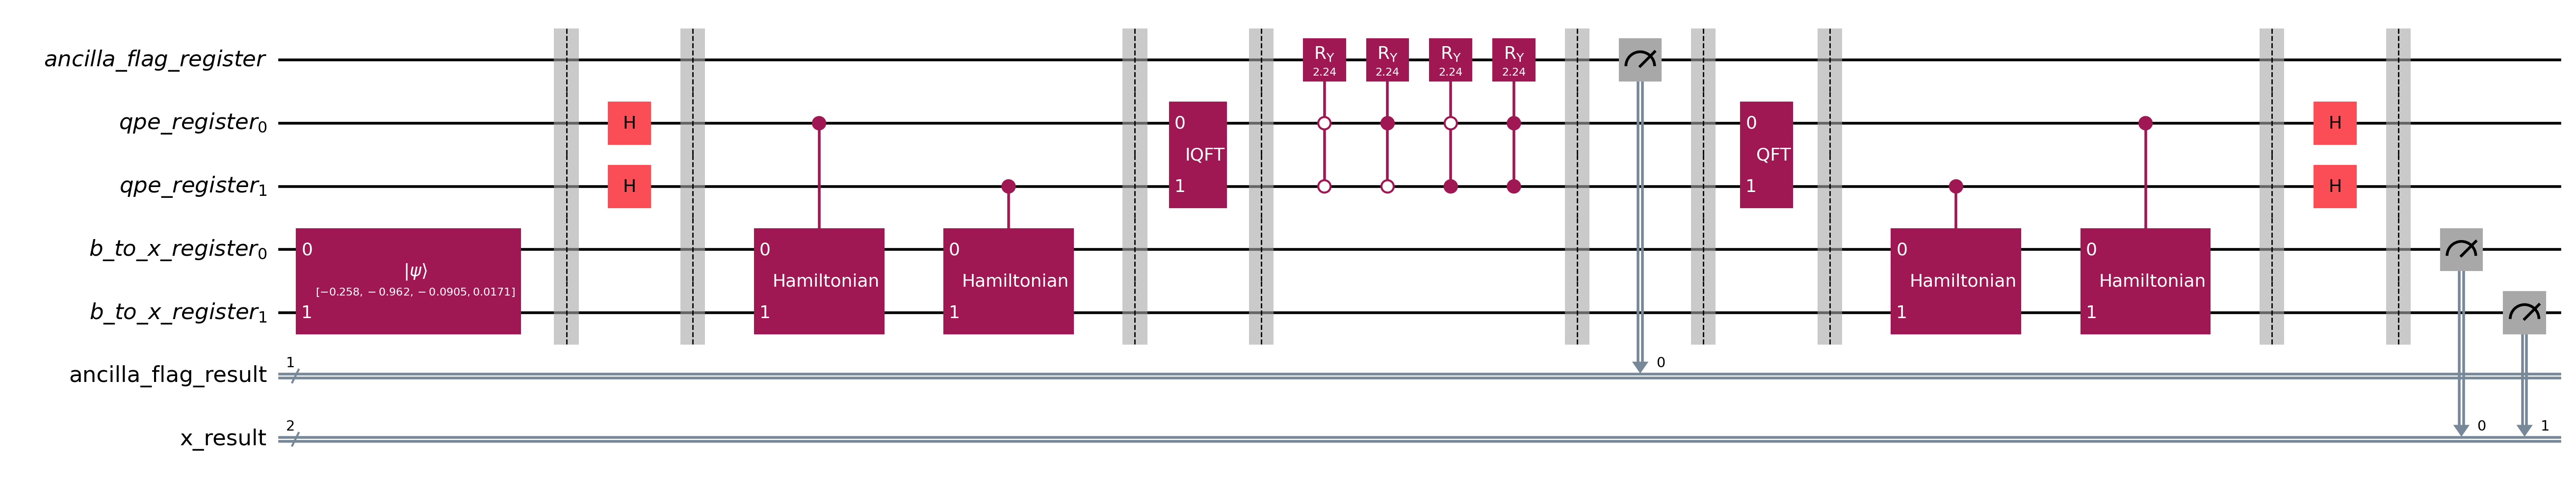

In [4]:
hhl = HHL(
    state_prep = StatePrep(method='default'),
    readout = 'measure_x',
    #swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = math.log2(len(b)),
    t0 = 2 * np.pi)

hhl_circuit = hhl.build_circuit(A, b)
hhl_circuit.draw(output='mpl', fold=-1)

In [5]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [6]:
backend = service.backend("ibm_boston")
transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
transpiled_hhl_circuit = transpiler.optimize()
print(transpiled_hhl_circuit.count_ops())

OrderedDict([('sx', 603), ('rz', 516), ('cz', 271), ('x', 41), ('barrier', 9), ('measure', 3), ('reset', 2)])


# Now lets see what size problem we can solve with a budget of 5-10k CZ gates

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit.gate import Gate

def count_two_qubit_gates(circuit):
    """
    Counts the total number of 2-qubit gates in a Qiskit circuit.
    """
    count = 0
    # Iterate over all instructions in the circuit's data
    for instruction in circuit.data:
        # Check if the instruction is a gate and acts on exactly 2 qubits
        if isinstance(instruction.operation, Gate) and len(instruction.qubits) == 2:
            count += 1
    return count

In [8]:
sizes = [2, 4, 8, 16, 32]

boston_2q_counts = []  # IBM Heron r3 architecture (heavy-hex)
miami_2q_counts = []   # IBM NightHawk architecture (square lattice)
H1_2q_counts = [3, 88, 736, 4819]  # Quantinuum H1 architecture, manually added from nexus

for problem_size in sizes:
    problem = generate_problem(problem_size)
    A = problem["A"]
    b = problem["b"]

    A = A / np.linalg.norm(b)
    b = b / np.linalg.norm(b)

    hhl = HHL(
        state_prep=StatePrep(method="default"),
        readout="measure_x",
        num_qpe_qubits=int(math.log2(len(b))),
        t0=2 * np.pi,
    )

    # build the circuit
    hhl_circuit = hhl.build_circuit(A, b)

    # define the backends
    boston = service.backend("ibm_boston")
    miami = service.backend("ibm_miami")

    # transpile to backends
    boston_transpiler = Transpiler(circuit=hhl_circuit, backend=boston, optimization_level=3)
    boston_hhl_circuit = boston_transpiler.optimize()
    boston_2q_gates = count_two_qubit_gates(boston_hhl_circuit)
    boston_2q_counts.append(boston_2q_gates)

    miami_transpiler = Transpiler(circuit=hhl_circuit, backend=miami, optimization_level=3)
    miami_hhl_circuit = miami_transpiler.optimize()
    miami_2q_gates = count_two_qubit_gates(miami_hhl_circuit)
    miami_2q_counts.append(miami_2q_gates)

    # map problem_size = 2,4,8,16 -> index = 0,1,2,3
    # h1_idx = int(math.log2(problem_size)) - 1
    # h1_2q_gates = H1_2q_counts[h1_idx]

    print(
        f"problem size: {problem_size}, "
        f"boston 2q count: {boston_2q_gates}, "
        f"miami 2q count: {miami_2q_gates}"
        # f"H1 2q count: {h1_2q_gates}"
    )

problem size: 2, boston 2q count: 4, miami 2q count: 4
problem size: 4, boston 2q count: 267, miami 2q count: 252
problem size: 8, boston 2q count: 2131, miami 2q count: 1969
problem size: 16, boston 2q count: 13102, miami 2q count: 12668
problem size: 32, boston 2q count: 70190, miami 2q count: 67840


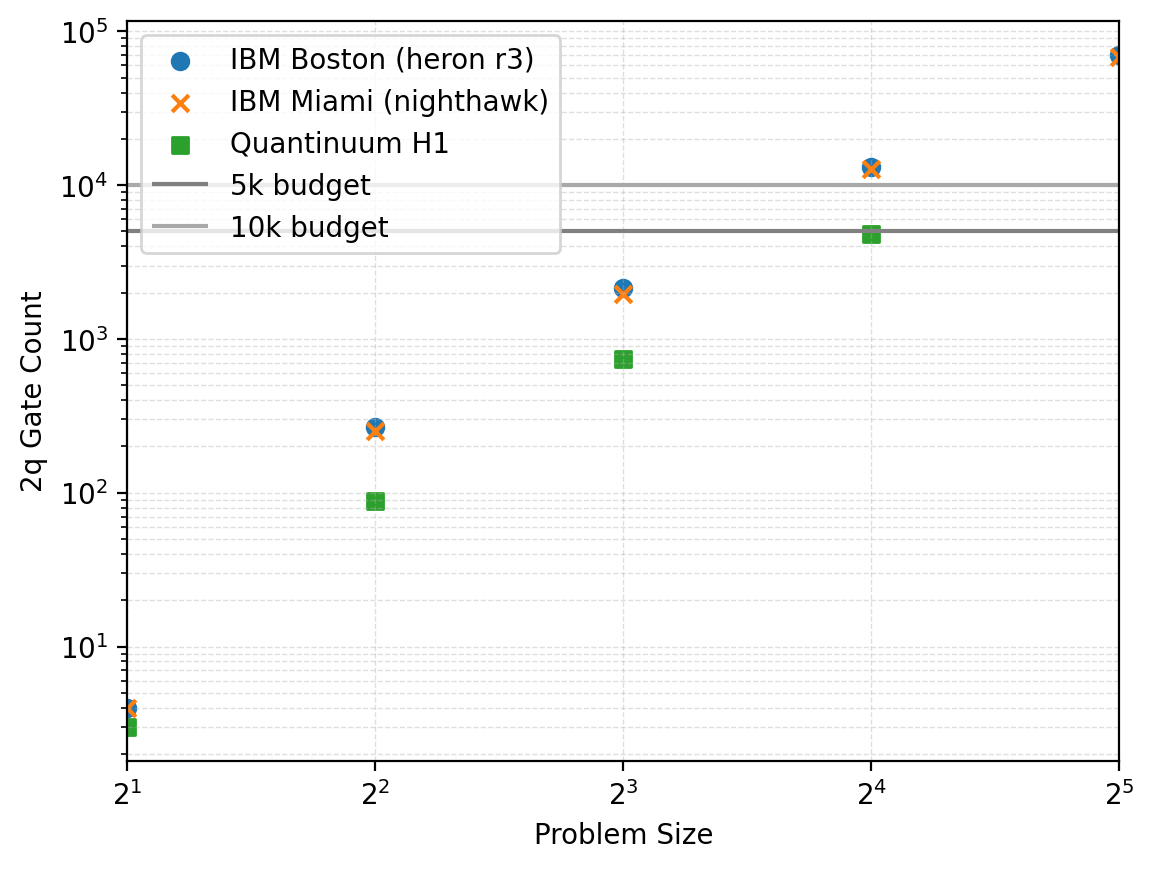

In [9]:
from matplotlib.ticker import LogLocator, FuncFormatter


def format_pow2(x, _pos):
    if x <= 0:
        return ""
    exponent = int(np.log2(x))
    coeff = x / 2**exponent
    coeff_str = "" if np.isclose(coeff, 1) else f"{coeff:g}"
    return f"{coeff_str}2^{exponent}"


ax = plt.gca()
ax.set_xscale("log", base=2)  # use powers of 2
ax.xaxis.set_major_locator(LogLocator(base=2))  # ticks at 2^n
ax.xaxis.set_major_formatter(FuncFormatter(format_pow2))

plt.scatter(sizes, boston_2q_counts, marker='o', label="IBM Boston (heron r3)")
plt.scatter(sizes, miami_2q_counts, marker='x', label="IBM Miami (nighthawk)")
plt.scatter(sizes[:-1], H1_2q_counts, marker='s', label="Quantinuum H1")

plt.hlines(5000, sizes[0], sizes[-1], color="grey", label="5k budget")
plt.hlines(10000, sizes[0], sizes[-1], color="darkgrey", label="10k budget")

plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Problem Size")
plt.ylabel("2q Gate Count")
plt.xlim(sizes[0], sizes[-1])
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
plt.legend()
plt.show()